Nome: Ruy Ovídio Perrelli de Melo

Email: ropm@cesar.school

Neural Networks Homer and Bart Classification (https://www.kaggle.com/datasets/juniorbueno/neural-networks-homer-and-bart-classification)

# Treinamento com interface de alto nível

## Importação das bibliotecas

In [1]:
# http://pytorch.org/
from os.path import exists

import torch

In [2]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import cv2
import os

In [3]:
import numpy as np

In [4]:
from google.colab.patches import cv2_imshow

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carregamento do dataset e manipulações

In [6]:
images_path = '/content/drive/MyDrive/RNA e Deep Learning/Trabalho Final/homer_bart_1'

In [7]:
files = [os.path.join(images_path, f) for f in sorted(os.listdir(images_path))]

In [8]:
# definindo as alturas e larguras para fazer o resize das imagens
image_height = 64
image_widtg = 64

In [9]:
images = []
labels = []

In [10]:
for path_image in files:
  image = cv2.imread(path_image)
  #fazendo o resizing das imagens
  image_resized = cv2.resize(image, (image_height, image_widtg))
  images.append(image_resized)


  #definindo as labens para cada imagem
  name_image = os.path.basename(path_image)
  if 'homer' in name_image.lower():
      labels.append(0)  # Label 0 para imagens de Homer
  if 'bart' in name_image.lower():
      labels.append(1)  # Label 1 para imagens de Bart
  #print(f'image name: {os.path.basename(path_image)}, image label: {labels[len(labels)-1]}', )

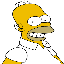

0


In [11]:
# testando o carregamento de imagens e a label
test_index = 199
cv2_imshow(images[test_index])
print(labels[test_index])

In [12]:
# conversao para numpy array e tamem normalizando os valores rgb da imagem
images = np.array(images).astype('float32') / 255.0
labels = np.array(labels)

In [13]:
class HomerBartDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [14]:
# Transformação para converter a imagem em tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizando as imagens
])

In [15]:
# Criação do dataset customizado
dataset = HomerBartDataset(images, labels, transform=transform)

In [16]:
# Divisão do dataset em treinamento e validação
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

## Criação da rede

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 64 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net()

## Treinamento

### Criando o objeto de treinamento

In [23]:
def train(log_interval, dry_run, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break

In [32]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return all_preds, all_targets

## Avaliação

In [33]:
use_cuda = torch.cuda.is_available()

torch.manual_seed(1111)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 1000}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

train_loader = DataLoader(train_dataset, **train_kwargs)
val_loader = DataLoader(val_dataset, **test_kwargs)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 14
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
log_interval = 10

for epoch in range(1, epochs + 1):
    train(log_interval, False, model, device, train_loader, optimizer, epoch)
    test(model, device, val_loader)
    scheduler.step()

torch.save(model.state_dict(), "homer_bart_classification.pt")

Train Epoch: 1 [0/215 (0%)]	Loss: 0.694022

Test set: Average loss: 41.1971, Accuracy: 36/54 (67%)

Train Epoch: 2 [0/215 (0%)]	Loss: 62.799591

Test set: Average loss: 1.4766, Accuracy: 24/54 (44%)

Train Epoch: 3 [0/215 (0%)]	Loss: 1.044284

Test set: Average loss: 0.9218, Accuracy: 37/54 (69%)

Train Epoch: 4 [0/215 (0%)]	Loss: 10.682805

Test set: Average loss: 0.5564, Accuracy: 42/54 (78%)

Train Epoch: 5 [0/215 (0%)]	Loss: 0.528498

Test set: Average loss: 0.5990, Accuracy: 40/54 (74%)

Train Epoch: 6 [0/215 (0%)]	Loss: 0.468392

Test set: Average loss: 0.4938, Accuracy: 41/54 (76%)

Train Epoch: 7 [0/215 (0%)]	Loss: 0.390388

Test set: Average loss: 0.4717, Accuracy: 44/54 (81%)

Train Epoch: 8 [0/215 (0%)]	Loss: 0.448986

Test set: Average loss: 0.5183, Accuracy: 42/54 (78%)

Train Epoch: 9 [0/215 (0%)]	Loss: 0.349428

Test set: Average loss: 0.4600, Accuracy: 43/54 (80%)

Train Epoch: 10 [0/215 (0%)]	Loss: 0.376424

Test set: Average loss: 0.4424, Accuracy: 43/54 (80%)

Train 


Test set: Average loss: 0.4558, Accuracy: 43/54 (80%)



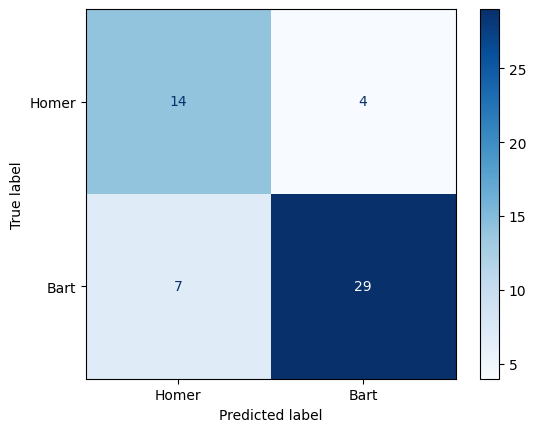

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Geração da matriz de confusão
all_preds, all_targets = test(model, device, val_loader)
conf_matrix = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Homer', 'Bart'])

# Plot da matriz de confusão
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Conclusão

- Durante a fase de carregamento do dataset e manipuações dos dados, foi feito o resize das imagens e tambem feito a normalização das imagens dividindo por 255, tudo isso serve para manter uma padronização e ajudar na classificação das imagens. Alem das classificações das labels da imagem, foi criada a classe para facil manipulaçao do array de valores de imagens e dos labels. Após, Foi feita uma nova normalização de acordo com a media e variancia, e divido o dataset em treino (80%) e teste (20%)
- Na fase de definição do modelo, foi definida uma camada de entrada com flatten, tres camadas linearas com ativação ReLU e a camada de saída linear para as duas classes.
- Durante a fase de treinamento e avaliação, o modelo foi treinado durante 14 epocas, com o otimizador Adam usando um learning rate de 0.01. Essas configurações resutaram numa acuracia de 80% para o modelo, com uma perda média de 0.5441. Naturalmente nas primeiras epocas houve um bom aumento de acuracia, ,as decidi nao aumentar maiso numero de epocas pois a acuracia nao se alterava muito. O learning rate que mais se adequou foi de 0.01 pois trouxe uma estabilidade durante o treinamento. O resultado foi razoavel, trazendo uma acuracia de 80% e 43 classificações certas de 54 totais, o que pode ser observado tambem na matriz de confusao acima